# Большое практическое задание 2

# Применение линейных моделей для определения токсичности комментария

## курс "Машинное обучение 1", программа OzonMasters, 2021

## Студент: Байчоров Альберт

## Формулировка задания
Данное задание направлено на ознакомление с линейными моделями и градиентными методами обучения. В
задании необходимо: <br>
1. Написать на языке Python собственную реализацию линейного классификатора с произвольной функцией потерь и реализацию функции и градиента функции потерь для логистической регрессии. Реализации можно частично проверить через юнит-тесты и с помощью системы ejudge в соответствующем соревновании. <br><br> **Внимание.** Прохождение всех тестов в соревновании не гарантирует правильность решения. 


2. Вывести все необходимые формулы, привести выкладки в отчёте. 


3. Провести описанные ниже эксперименты с модельными данными и приложенным датасетом в данном ноутбуке. Подготовить отчёт о проделанной работе. Удалите черновые выводы, оставьте только тот код, который является ответом к пунктам задания. Сохраните ноутбук в форматах .ipynb и .html одновременно. <br><br> **Замечание.** Чтобы экспорировать jupyter notebook в .html нужно выбрать: `File -> Download as -> HTML (.html)`. Для экспорта notebook в .html в Google Colab, воспользуйтесь [следующим кодом](https://gist.github.com/vbugaevskii/b9c6181f2ad83e11f5b9c92d315cb2de). Большая просьба: подписывайте свой отчет (в названии файла и внутри ноутбука).


4. В систему проверки необходимо сдать отчёт в обоих форматах и .zip архив с написанными модулями. <br><br> Большая просьба: jupyter notebook и html файл не запаковывать в архив, а сдавать отдельно.


### Некоторые полезные советы
1. Для того, чтобы не перезагружать jupyter notebook каждый раз после того, как вы внесли изменения в модуль knn, можно добавить ячейку с таким содержимым:
```python
%load_ext autoreload
%autoreload 2
```


2. Не нужно копировать свой код из модулей в jupyter notebook, пользуйтесь им, как если бы это была библиотека. Для этого поместите директорию `modules` рядом с notebook-ом. Пример, как может выглядеть содержимое вашей рабочей директории:
```text
tree
    ---modules
    ------__init__.py
    ------linear_model.py
    ------losses.py
    ------utils.py
    ------tests.py
    ------tests_bouns.py
    HW2_*.ipynb
```

## Теоретическая часть (1 балл)
Выведите формулу градиента функции потерь (по параметру $w$) для задачи бинарной логистической регрессии.

$$L(a(x), y) = \log(1 + \exp(-y\langle w, x\rangle)), \quad y \in \{-1, 1\}$$

Запишите вывод градиента ниже.

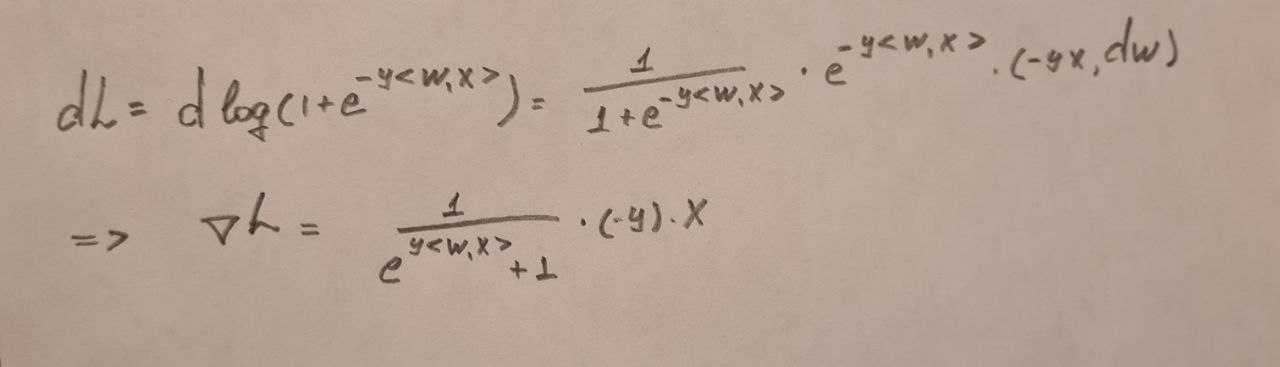

$$
\nabla L = \dfrac{-y}{1+ \exp{y<x,w>}} x
$$


## Реализация алгоритмов (9 баллов)
Прототипы функций должны строго соответствовать прототипам, описанным в спецификации и проходить все
тесты. Задание, не проходящее все тесты, приравнивается к невыполненному. 


При написании необходимо пользоваться стандартными средствами языка Python, библиотеками `numpy, scipy и matplotlib`. Библиотекой `scikit-learn` для реализаций пользоваться запрещается, но разрешается использовать её в процессе экспериментов. Все
подробности реализации алгоритмов подробно описаны в [спецификации](https://drive.google.com/file/d/1cby1SXsS0TkeFd-3AkE2j1JhKYU9Er1N/view) к заданию.


Ожидается, что реализациия всех классов и функций будет максимально эффективной. Дополнительно вам предоставлены открытые тесты, которые находятся в модуле `modules`. Чтобы запустить тесты в консоли требуется выполнить команду:
```c
$ pytest ./modules/tests.py

```

Разрешается дополнять файл тестами для самопроверки. Доп баллы за написание своих тестов не будет :)


## Предобработка данных (2 балла)
Импортируйте все, что вам потребуется для экспериментов:

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import re
import nltk
import time
import seaborn as sns

from modules.linear_model import LinearModel
from modules.losses import BinaryLogisticLoss, MultinomialLoss
from modules.utils import get_numeric_grad, compute_balanced_accuracy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

### 1. Загрузка даннных
Эксперименты этого задания необходимо проводить на датасете, содержащим комментарии из раздела обсуждений английской Википедии, который был преобразован для решения задачи бинарной классификации: является ли данный комментарий токсичным или нет. Подробнее об исходных данных [здесь](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). Требуемый для выполнения данного задания датасет можно найти по следующей [ссылке](https://drive.google.com/file/d/1FLTAFR29Koi4YDkLUdVQWNabnBQCTFbn/view). 


Данные в датасете записаны в формате `csv`. Для базовой части экспериментов используйте в качестве целевой переменной столбец `is_toxic`. Обратите внимание на метки классов в датасете, замените их на те, которые ожидает увидеть на вход ваша реализация `LinearModel`.

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.loc[train['is_toxic'] == 1, 'is_toxic'] = -1
test.loc[test['is_toxic'] == 1, 'is_toxic'] = -1
train.loc[train['is_toxic'] == 0, 'is_toxic'] = 1
test.loc[test['is_toxic'] == 0, 'is_toxic'] = 1

In [4]:
train[train['is_toxic']==-1]

,comment_text,is_toxic,toxic_level,insult,obscene,obscene_and_insult,no_obscene_no_insult
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,-1,4,0,0,1,0
12,Hey... what is it..\n@ | talk .\nWhat is it......,-1,1,0,0,0,1
16,"Bye! \n\nDon't look, come or think of comming ...",-1,1,0,0,0,1
42,You are gay or antisemmitian? \n\nArchangel WH...,-1,4,0,0,1,0
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",-1,3,0,0,1,0
...,...,...,...,...,...,...,...
159494,"""\n\n our previous conversation \n\nyou fuckin...",-1,4,0,0,1,0
159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR,-1,2,1,0,0,0
159541,Your absurd edits \n\nYour absurd edits on gre...,-1,3,0,0,1,0
159546,"""\n\nHey listen don't you ever!!!! Delete my e...",-1,2,1,0,0,0


### 2. Предобработка текста
Произведите предварительную обработку текста. Приведите все тексты к нижнему регистру. Замените в тексте все символы, не являющиеся буквами и цифрами, на пробелы. Примените алгоритм лемматизации (например, `WordNetLemmatizer` из библотеки `nltk`) к коллекции. Удалите из текста стоп-слова (например, используя список стоп-слов из `nltk`).

**Замечание.** Полезные функции: `str.lower, str.split, str.isalnum, re.sub, re.split`.

In [5]:
#nltk.download('wordnet')
#nltk.download('stopwords')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
stop_words_set = set(nltk.corpus.stopwords.words('english'))
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
def stop_words_filter(tokens):
    return ' '.join([word for word in tokens if not word in stop_words_set])

In [6]:
train

,comment_text,is_toxic,toxic_level,insult,obscene,obscene_and_insult,no_obscene_no_insult
0,Explanation\nWhy the edits made under my usern...,1,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,1,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",1,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",1,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",1,0,0,0,0,0
...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",1,0,0,0,0,0
159567,You should be ashamed of yourself \n\nThat is ...,1,0,0,0,0,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",1,0,0,0,0,0
159569,And it looks like it was actually you who put ...,1,0,0,0,0,0


In [7]:
train.comment_text = train.comment_text.str.lower()
train.comment_text = train.comment_text.replace(to_replace=r'\W|_', value=' ', regex=True)
train.comment_text = train.comment_text.replace(to_replace=r'\b\d+\b', value='', regex=True)
train.comment_text = train.comment_text.apply(lemmatize_text)

test.comment_text = test.comment_text.str.lower()
test.comment_text = test.comment_text.replace(to_replace=r'\W', value=' ', regex=True)
test.comment_text = test.comment_text.replace(to_replace=r'\b\d+\b', value='', regex=True)
test.comment_text = test.comment_text.apply(lemmatize_text)


In [8]:
%%time
train.comment_text = train.comment_text.apply(stop_words_filter)
test.comment_text = test.comment_text.apply(stop_words_filter)

CPU times: user 1.14 s, sys: 17.6 ms, total: 1.16 s
Wall time: 1.15 s


In [9]:
train.comment_text[train.is_toxic == -1]

6                               cocksucker piss around work
12        hey talk exclusive group wp taliban good destr...
16                  bye look come think comming back tosser
42        gay antisemmitian archangel white tiger meow g...
43                                   fuck filthy mother dry
                                ...                        
159494    previous conversation fucking shit eating libe...
159514                              mischievious pubic hair
159541    absurd edits absurd edits great white shark wa...
159546    hey listen ever delete edits ever annoyed wwe ...
159554    going keep posting stuff u deleted fucking sit...
Name: comment_text, Length: 16225, dtype: object

In [10]:
test.comment_text[test.is_toxic == -1]

8        arab committing genocide iraq protest europe m...
24                     dj robinson gay hell suck dick much
29                                  fuck anti semitic cunt
38           dare vandalize page hm beagle vandalize demon
40          arrogant self serving immature idiot get right
                               ...                        
63877                                    nigel crazy idiot
63935                                     well feel stupid
63945    fourth baldrick possibly cleverer made doe any...
63962    iran right iran wa drone wa spreading homosexu...
63976    mel gibson nazi bitch make shitty movie ha muc...
Name: comment_text, Length: 6243, dtype: object

### 3. Train/val
Разделите данные на обучение и валидацию. Для валидации выберете $30\%$ случайных объектов из датасета. Рекомендуется использовать функцию `sklearn.model_selection.train_test_split`.

In [11]:
X_train, X_val, y_train, y_val = train_test_split(train.comment_text, 
                                                  train.is_toxic, 
                                                  test_size=0.30, 
                                                  random_state=300599)
X_test, y_test = test.comment_text, test.is_toxic

In [12]:
X_test

0        thank understanding think highly would revert ...
1                                   dear god site horrible
2        somebody invariably try add religion really me...
3        say right type type institution needed case th...
4        adding new product list make sure relevant add...
                               ...                        
63973    jerome see never got around surprised looked e...
63974    lucky bastard http wikimediafoundation org wik...
63975                        shame want speak gay romanian
63976    mel gibson nazi bitch make shitty movie ha muc...
63977    unicorn lair discovery supposedly unicorn lair...
Name: comment_text, Length: 63978, dtype: object

In [13]:
X_val

64802     always thought body force wa ratio force mass ...
137404                                             ip human
61975                                   kingpin13 word cunt
69104     style border spacing 8px margin 0px 8px width ...
126489       would rather unnecessary chat wit contribution
                                ...                        
145593    brief glance left impression wa better classif...
107444                                            u mad bro
112471    alabaman know recognised delete denying histor...
125096    splitting article editor think dividing articl...
138292    vandalization section engine mean starting con...
Name: comment_text, Length: 47872, dtype: object

In [14]:
X_train

111053    ive changed heading wa physic section appeared...
37437     gaming champion rich gallup often make allusio...
85182     mark really entity made pure energy still pain...
111486                                     h j 8th february
56934     welcome note thank welcome note page pointing ...
                                ...                        
70666     jfdwolff hopeless failure stomach defeat jfdwo...
104887                      way win game think read winning
79432       still say present part book give quotation book
3229      page wa deleted lack notability meet least two...
133791    telling look page still wanting accept reliabl...
Name: comment_text, Length: 111699, dtype: object

### 4. Tf-idf
Преобразуйте текст в разреженную матрицу `scipy.sparse.csr_matrix`, где значение $x$ в позиции $(i, j)$ сответствует tf-idf характеристке $j$-го слова в $i$-ом документе. Рекомендуется использовать конструктор `sklearn.feature_extraction.text.TfidfVectorizer`. Добавьте в данные единичный столбец на **нулевой** позиции.

**Замечание 1.** У `TfidfVectorizer` есть несколько методов для работы, используйте `fit_transform` и `fit` для обучающей выборки, используйте `transform` для тестовой.


**Замечание 2.** Используйте параметр `min_df`, чтобы уменьшить размерность данных и ускорить проведение экспериментов. Рекомендуется использовать `min_df` не меньше $5$.


**Замечание 3.** Для добавления единичного столбца, можно воспользоваться следующей инструкцией:
```python
from scipy.sparse import hstack, csr_matrix
X = csr_matrix(hstack([csr_matrix(np.ones((X.shape[0], 1))), X]))
```

In [15]:
trfrm = TfidfVectorizer(strip_accents='unicode', analyzer='word', stop_words='english', min_df = 5)
X_train = trfrm.fit_transform(X_train)
X_val   = trfrm.transform(X_val)
X_test  = trfrm.transform(X_test)

In [16]:
X_train = csr_matrix(hstack([csr_matrix(np.ones((X_train.shape[0], 1))), X_train]))
X_test = csr_matrix(hstack([csr_matrix(np.ones((X_test.shape[0], 1))), X_test]))
X_val = csr_matrix(hstack([csr_matrix(np.ones((X_val.shape[0], 1))), X_val]))

#### Ответьте на следующие вопросы

1. Поясните, почему мы хотим хранить данные в разреженных матрицах CSR формата? Почему для данной задачи этот формат подходит лучше DOK формата (словарь, где ключ это пара (строка, столбец), а значение это соответствующий строке и столбцу элемент матрицы)?

В данных прутствует много нулей, в силу того, что формируется словарь. Таким образом у нас будет большое колличество нулей в строках(врядли предложение содежит все слова из всех комментариев).

Для разреженных матриц нужны специальные операции, приспособленные к их структуре, работающие быстрее. Собственно, для CSR используются отдельные операции, работающие быстрее чем обычные методы numpy и Python.

## Эксперименты (13 баллов)

### 1. Исследование параметров градиентного спуска (3 балла)

В спецификации предлагается использовать следующую формулу для выбора темпа обучения $\eta_k$:


$$\eta_k  = \frac{\alpha}{k^{\beta}}, \quad \text{где $\alpha$, $\beta$ - заданные константы}, \; \text{$k$ - номер итерации}$$


Исследуйте поведение градиентного спуска для задачи логистической регрессии в зависимости от следующих параметров:

- параметр темпа обучения `step_alpha`
- параметр темпа обучения `step_beta`

Исследование поведения подразумевает анализ следующих зависимостей на обучающей и валидационной
выборках:

- зависимость значения функции потерь от реального времени работы метода
- зависимость значения функции потерь от эпохи метода
- значение метрики качества после обучения метода

В качестве метрики качества здесь и далее предлагается использовать сбалансированную точность (balanced accuracy), реализацию, совместимую с множеством меток $\{−1, 1\}$, можно найти в модуле `utils`.


**Замечание.** Для оценки времени долго работающих функций можно пользоваться либо функциями из модуля `time`, либо magic-командой `%time`, которая запускает код лишь один раз.


#### Приведите график / таблицу с результатами ваших экспериментов

In [19]:
%%time
bethas = np.arange(0.0, 3.0, 0.1)
alphas = np.logspace(-3, 0.5, num=10)
loss_function = BinaryLogisticLoss(l2_coef=1)
res = {'alpha': [], 'betha': [], 'time': [], 'loss': [],'loss_val' : [], 'acc': []}
for b in bethas:
    for a in alphas:
        model = LinearModel(loss_function,step_alpha=a, step_beta=b, max_iter=100, random_seed=1)
        start = time.time()
        inf = model.fit(X=X_train, y=y_train, w_0=None, trace=True, X_val=X_val, y_val=y_val)
        duration = time.time() - start
        res['time'].append(duration)
        res['betha'].append(b)
        res['alpha'].append(a)
        res['loss'].append(inf['func'][-1])
        res['loss_val'].append(inf['func_val'][-1])
        y_pred = model.predict(X_val, threshold=model.get_optimal_threshold(X_train, y_train))
        res['acc'].append(compute_balanced_accuracy(y_val, y_pred))

convergence: 9.015584160480309e-06 < 1e-05
convergence: 9.873872352619584e-06 < 1e-05
convergence: 9.721143105732395e-06 < 1e-05
convergence: 8.951977087244296e-06 < 1e-05
convergence: 9.98240691229451e-06 < 1e-05
convergence: 9.27583793976981e-06 < 1e-05
convergence: 9.769113608494005e-06 < 1e-05
convergence: 9.72264713624316e-06 < 1e-05
convergence: 9.757224825229443e-06 < 1e-05
convergence: 9.9792900676004e-06 < 1e-05
convergence: 9.95040505714575e-06 < 1e-05
convergence: 9.758983682978465e-06 < 1e-05
convergence: 9.839042192488937e-06 < 1e-05
convergence: 9.760280938700588e-06 < 1e-05
convergence: 9.78391820209054e-06 < 1e-05
convergence: 9.657090527363457e-06 < 1e-05
convergence: 9.805030590195853e-06 < 1e-05
convergence: 9.931389955397599e-06 < 1e-05
convergence: 9.721191719099705e-06 < 1e-05
convergence: 9.897826476092024e-06 < 1e-05
convergence: 9.856067162851225e-06 < 1e-05
convergence: 9.62539321454631e-06 < 1e-05
convergence: 9.436848247401399e-06 < 1e-05
convergence: 9.2235

In [20]:
res = pd.DataFrame.from_dict(res)

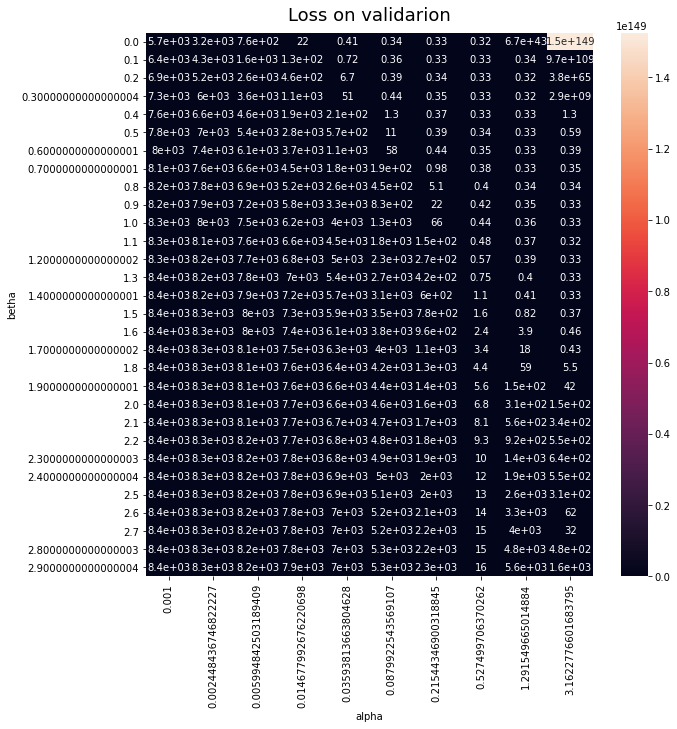

In [21]:
test1 = res.drop(columns = ['acc','time','loss'])
test1 = test1.pivot(index='betha', columns='alpha', values='loss_val')
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(test1, annot=True)
heatmap.set_title('Loss on validarion', fontdict={'fontsize':18}, pad=12);

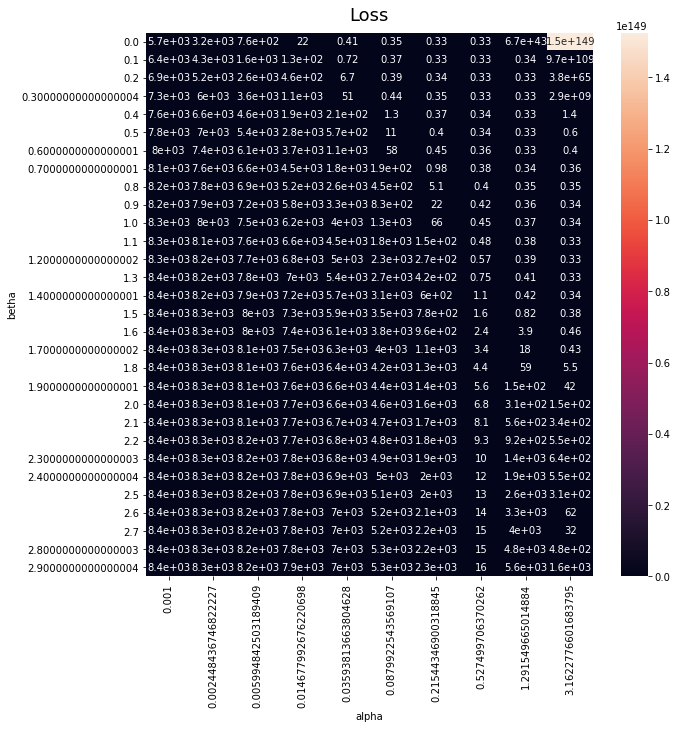

In [22]:
test1 = res.drop(columns = ['acc','time','loss_val'])
test1 = test1.pivot(index='betha', columns='alpha', values='loss')
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(test1, annot=True)
heatmap.set_title('Loss', fontdict={'fontsize':18}, pad=12);

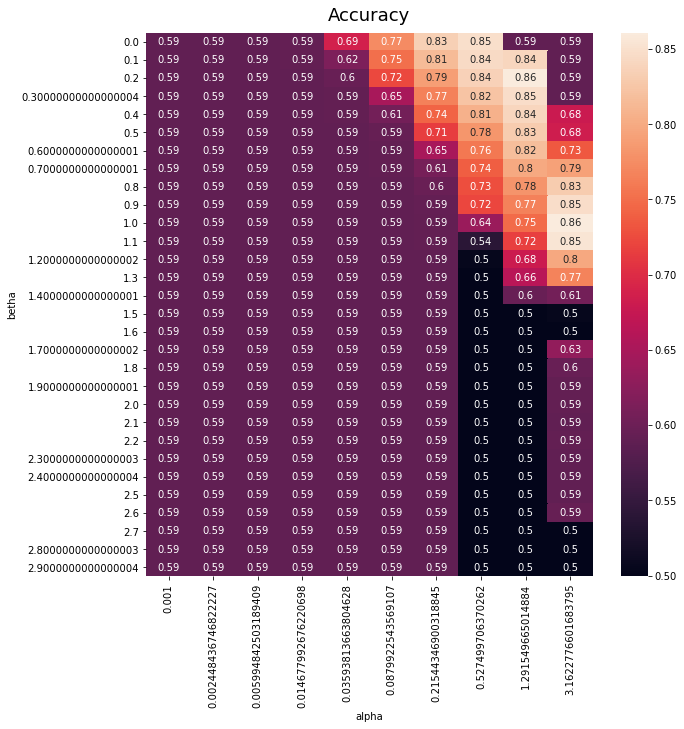

In [23]:
test1 = res.drop(columns = ['time','loss','loss_val'])
test1 = test1.pivot(index='betha', columns='alpha', values='acc')
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(test1, annot=True)
heatmap.set_title('Accuracy', fontdict={'fontsize':18}, pad=12);

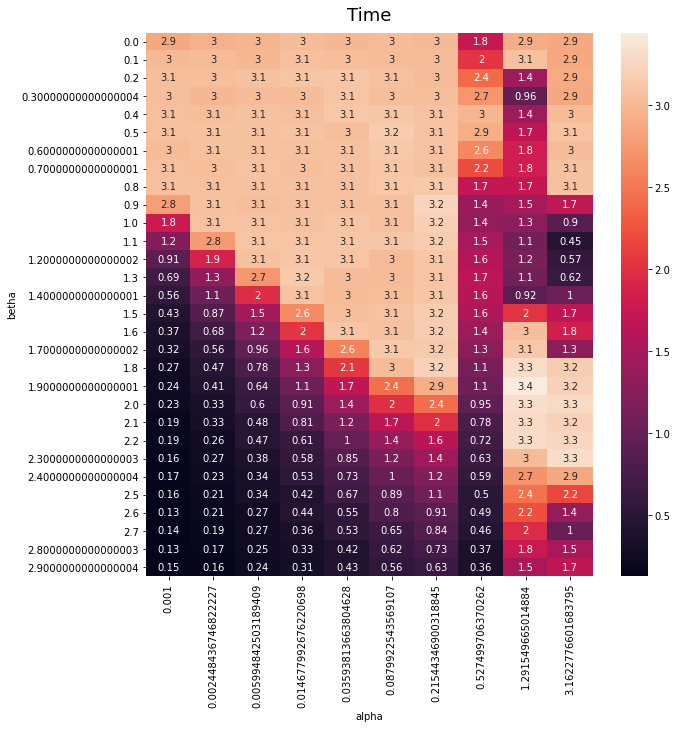

In [24]:
test1 = res.drop(columns = ['loss','acc','loss_val'])
test1 = test1.pivot(index='betha', columns='alpha', values='time')
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(test1, annot=True)
heatmap.set_title('Time', fontdict={'fontsize':18}, pad=12);

По таблицам видно, что некоторые алгоритмы вовсе не сходятся(возможно слишком большой или маленький шаг и алгоритмы не сошлись за 100 эпох к минимуму, а возможно они попали в некий локальный минимум)

Фукнция ошибки на валидации и трейне практически совпадает

Сравнивая разные гиперпараметры по таблицам Accuracy и Time видно, что существуют разные оптимальные по времени качеству гиперпараметры.

Возьмем 

$\beta$ = 0.2

$\alpha$ = 1.29

и посмотрим на кривую обучения

In [111]:
alpha = alphas[-2]
betha = bethas[2]

In [112]:
alpha

1.291549665014884

In [113]:
betha

0.2

In [114]:
 model = LinearModel(loss_function,step_alpha=alpha, step_beta=betha, max_iter=1000, random_seed=1)
%time
inf = model.fit(X=X_train, y=y_train, w_0=None, trace=True, X_val=X_val, y_val=y_val)
y_pred = model.predict(X_val, threshold=model.get_optimal_threshold(X_train, y_train))

print(compute_balanced_accuracy(y_val, y_pred))

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 11.9 µs
convergence: 8.951977087244296e-06 < 1e-05
0.8606679999956266


График обучения на трейне

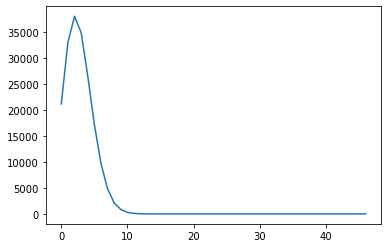

In [115]:
plt.plot(np.arange(len(inf['func'])),inf['func']);

Функционал ошибки на валидации при каждой эпохе

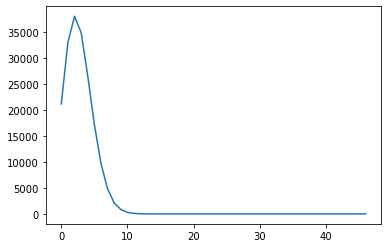

In [116]:
plt.plot(np.arange(len(inf['func_val'])),inf['func_val']);

#### Ответьте на следующие вопросы

1. По результатам экспериментов, какие параметры `step_alpha` и `step_beta` вы считаете наиболее оптимальными? Если пар оптимальных параметров получилось несколько, какую пару вы выберете для дальнейших экпериментов и почему?

$\beta$ = 0.2

$\alpha$ = 1.29


При таких значениях алгоритм сходится быстрее всего и достигается наименьший минимум при градиентном спуске, взвешенное accuracy также лучшее


2. Какие зависимости между параметрами `step_alpha`/`step_beta` и временем работы алгоритма/кол-ва эпох вы наблюдаете? Опишите свои наблюдения.

При уменьшении $\beta$ алгоритмы работают дольше. Возможно размер шага слишком большой и оптимизатор 'перепрыгивает' через минимумы. Также из-за слишком мелкого шага норма разности весов может оказаться меньше tolerance, что не позволяет модели сойтись к минимуму. Также при некоторых фиксированных $\alpha$, выбора между $\beta$ не так сильно влияет на скорость сходимости(например альфа ~ 0.5)
    
3. Поясните, в чём преимущество использования balanced accuracy для этой задачи по сравнению с обычной accuracy?

Классы несбалансированы, токсичных комментариев меньше чем нетоксичных, взвешенное среднее позволяет учесть это с помощью нормировки, обычная точность может быть завышенной, так возможно ситуация что мы везде предскажем что комментарий нетоксичен, и за счет большого обьема этих самых нетоксичных комментариев мы получим высокий accuracy, что не соответствует реальной работе алгоритма

### 2. Исследование параметров стохастического градиентного спуска (3 балла)
Исследуйте поведение стохастического градиентного спуска для задачи логистической регрессии в зависимости от следующих параметров:

- параметр темпа обучения `step_alpha`
- параметр темпа обучения `step_beta`
- размер подвыборки `batch_size`

**Замечание.** Обратите внимание, что в стохастическом случае необходимо строить зависимости метрик качества от эпохи метода. За одну эпоху через оптимизацию модели проходит $N$ объектов, где $N$ — длина обучающей выборки. Если вы реализуете семплирование согласно спецификации задания, то за одну эпоху каждый объект пройдёт через оптимизацию ровно один раз. В полном градиентном спуске одна эпоха метода соответствует одной итерации обучения.

#### Приведите график / таблицу с результатами ваших экспериментов

Посмотрим как ведет себя алгоритм при фиксированом `batch_size`

In [38]:
%%time

bethas = np.arange(0.0, 3.0, 0.1)
alphas = np.logspace(-3, 0.5, num=10)

res = {'alpha': [], 'betha': [], 'time': [], 'loss': [], 'acc': [], 'loss_val' : []}
for b in bethas:
    for a in alphas:
        loss_function = BinaryLogisticLoss(l2_coef=1.0)
        model = LinearModel(loss_function,step_alpha=a,batch_size=50000, step_beta=b, max_iter=100, random_seed=1)
        start = time.time()
        inf = model.fit(X=X_train, y=y_train, w_0=None, trace=True, X_val=X_val, y_val=y_val)
        duration = time.time() - start
        res['time'].append(duration)
        res['betha'].append(b)
        res['alpha'].append(a)
        res['loss'].append(inf['func'][-1])
        res['loss_val'].append(inf['func_val'][-1])
        y_pred = model.predict(X_val, threshold=model.get_optimal_threshold(X_train, y_train))
        res['acc'].append(compute_balanced_accuracy(y_val, y_pred))

convergence: 9.975793747856885e-06 < 1e-05
convergence: 9.882482664251726e-06 < 1e-05
convergence: 9.547514987268694e-06 < 1e-05
convergence: 8.728806331130925e-06 < 1e-05
convergence: 7.969135465401987e-06 < 1e-05
convergence: 9.717458428694415e-06 < 1e-05
convergence: 9.681342417221538e-06 < 1e-05
convergence: 9.46207820061154e-06 < 1e-05
convergence: 8.018591196418684e-06 < 1e-05
convergence: 9.434481028869906e-06 < 1e-05
convergence: 9.69028710735926e-06 < 1e-05
convergence: 9.37253172108151e-06 < 1e-05
convergence: 8.589797260639746e-06 < 1e-05
convergence: 8.629338124862587e-06 < 1e-05
convergence: 9.84914985519274e-06 < 1e-05
convergence: 9.750737358845777e-06 < 1e-05
convergence: 9.736082587611791e-06 < 1e-05
convergence: 8.986690217181702e-06 < 1e-05
convergence: 8.627524473217174e-06 < 1e-05
convergence: 9.65148836743026e-06 < 1e-05
convergence: 9.962436190826121e-06 < 1e-05
convergence: 8.766496134474169e-06 < 1e-05
convergence: 9.655635993853581e-06 < 1e-05
convergence: 9.6

convergence: 5.33175674934022e-06 < 1e-05
convergence: 7.793395056993368e-06 < 1e-05
convergence: 8.63800645397837e-06 < 1e-05
convergence: 7.80888280793659e-06 < 1e-05
convergence: 7.635280754286451e-06 < 1e-05
convergence: 8.234339073065074e-06 < 1e-05
convergence: 6.7932927692471305e-06 < 1e-05
convergence: 9.340702631558093e-06 < 1e-05
convergence: 7.443102440485498e-06 < 1e-05
convergence: 4.055634822925852e-06 < 1e-05
convergence: 8.572698885749273e-06 < 1e-05
convergence: 9.731096130545946e-06 < 1e-05
convergence: 8.593885415549009e-06 < 1e-05
convergence: 9.584366310206838e-06 < 1e-05
convergence: 8.12782565923812e-06 < 1e-05
convergence: 7.279902885100829e-06 < 1e-05
convergence: 5.2070004978828e-06 < 1e-05
convergence: 9.803613947232936e-06 < 1e-05
convergence: 9.017228431621134e-06 < 1e-05
convergence: 2.9400444629516906e-06 < 1e-05
convergence: 5.994132867764647e-06 < 1e-05
convergence: 6.4296471413561384e-06 < 1e-05
convergence: 9.28457244517321e-06 < 1e-05
convergence: 8.

In [66]:
res = pd.DataFrame.from_dict(res)

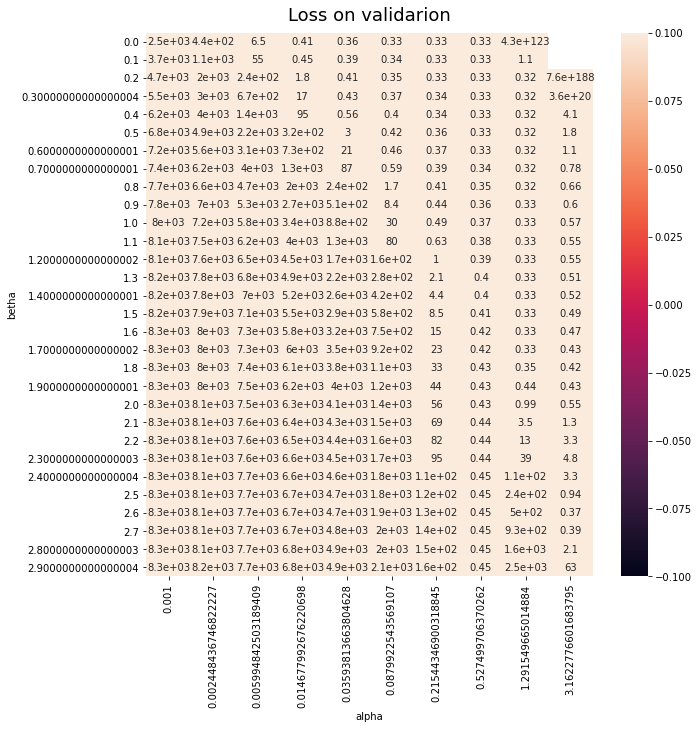

In [77]:
test1 = res.drop(columns = ['acc','time','loss'])
test1 = test1.pivot(index='betha', columns='alpha', values='loss_val')
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(test1, annot=True)
heatmap.set_title('Loss on validarion', fontdict={'fontsize':18}, pad=12);

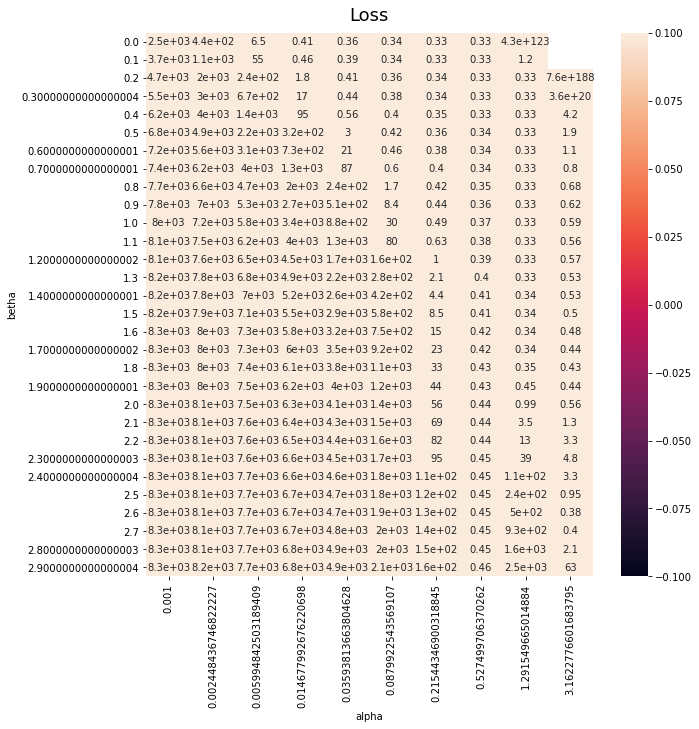

In [68]:
test1 = res.drop(columns = ['acc','time','loss_val'])
test1 = test1.pivot(index='betha', columns='alpha', values='loss')
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(test1, annot=True)
heatmap.set_title('Loss', fontdict={'fontsize':18}, pad=12);

Опять же функция ошибки на трейне и валидации совпадают, пропущенные значения в таблице - бесконечности, вследствие большого шага.

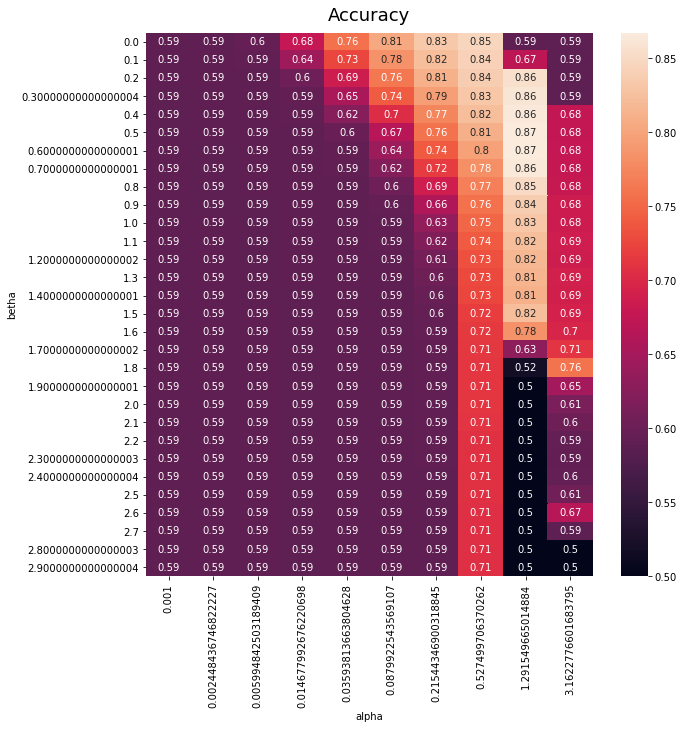

In [69]:
test1 = res.drop(columns = ['time','loss','loss_val'])
test1 = test1.pivot(index='betha', columns='alpha', values='acc')
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(test1, annot=True)
heatmap.set_title('Accuracy', fontdict={'fontsize':18}, pad=12);

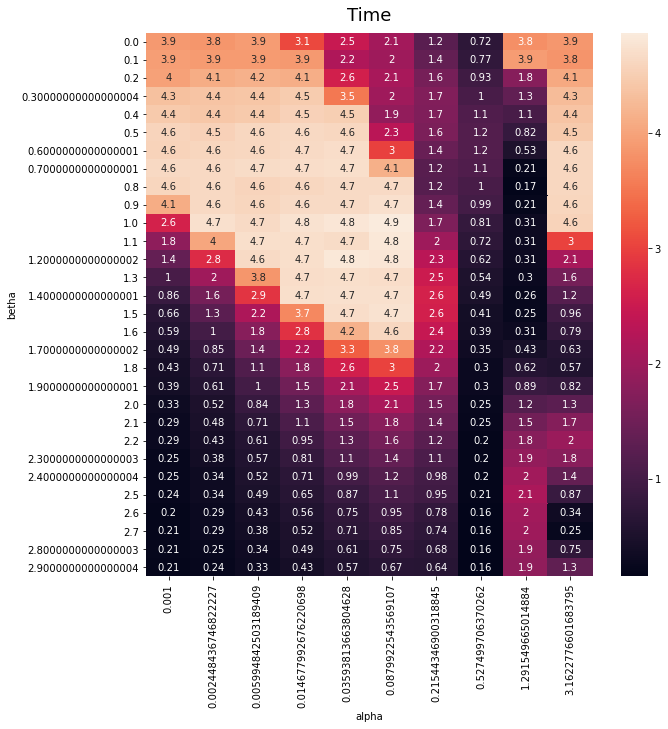

In [70]:
test1 = res.drop(columns = ['loss','acc','loss_val'])
test1 = test1.pivot(index='betha', columns='alpha', values='time')
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(test1, annot=True)
heatmap.set_title('Time', fontdict={'fontsize':18}, pad=12);

Возьмем 

$\beta$ = 0.6

$\alpha$ = 1.29

In [128]:
betha = bethas[6]

In [129]:
alpha = alphas[-2]

In [130]:
betha

0.6000000000000001

In [131]:
alpha

1.291549665014884

Подберем размер батча

In [132]:
%%time
batch = [200,500,1000,5000,10000,20000,50000,80000,100000]
res = {'batch': [], 'time': [], 'loss': [], 'acc': []}
for b in batch:
    loss_function = BinaryLogisticLoss(l2_coef=1.0)
    model = LinearModel(loss_function,step_alpha=alpha,batch_size=b, step_beta=betha, max_iter=100, random_seed=1)
    start = time.time()
    inf = model.fit(X=X_train, y=y_train, w_0=None, trace=True, X_val=X_val, y_val=y_val)
    duration = time.time() - start
    res['time'].append(duration)
    res['batch'].append(b)
    res['loss'].append(inf['func'][-1])
    y_pred = model.predict(X_val, threshold=model.get_optimal_threshold(X_train, y_train))
    res['acc'].append(compute_balanced_accuracy(y_val, y_pred))

convergence: 9.98047361581502e-06 < 1e-05
convergence: 8.91201557594052e-06 < 1e-05
convergence: 8.911365124351508e-06 < 1e-05
convergence: 4.892737415127048e-06 < 1e-05
convergence: 9.048347246864754e-06 < 1e-05
convergence: 8.197474909010493e-06 < 1e-05
convergence: 8.158221301536789e-06 < 1e-05
convergence: 8.259598328246811e-06 < 1e-05
convergence: 8.208438154909827e-06 < 1e-05
CPU times: user 2min 51s, sys: 42.8 s, total: 3min 34s
Wall time: 31.3 s


In [133]:
res = pd.DataFrame.from_dict(res)

In [134]:
res

,batch,time,loss,acc
0,200,13.683917,0.330560,0.815339
1,500,5.572619,0.339652,0.825272
2,1000,3.312017,0.338102,0.842371
3,5000,1.465528,0.334286,0.866805
4,10000,1.158966,0.333717,0.866818
5,20000,1.027247,0.332437,0.869821
6,50000,0.461233,0.331210,0.866711
7,80000,0.417601,0.330971,0.842483
8,100000,0.356544,0.331166,0.840878


In [135]:
loss_function = BinaryLogisticLoss(l2_coef=1.0)
model = LinearModel(loss_function,step_alpha=alpha,batch_size=20000, step_beta=betha, max_iter=100, random_seed=1)
inf = model.fit(X=X_train, y=y_train, w_0=None, trace=True, X_val=X_val, y_val=y_val)
y_pred = model.predict(X_val, threshold=model.get_optimal_threshold(X_train, y_train))
print(compute_balanced_accuracy(y_val, y_pred))

convergence: 8.197474909010493e-06 < 1e-05
0.8698211425413536


Кривая обучения на трейне

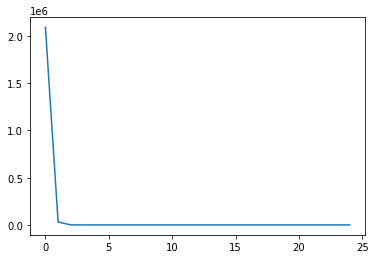

In [136]:
plt.plot(np.arange(len(inf['func'])),inf['func']);

Значения функционала ошибки на валидации

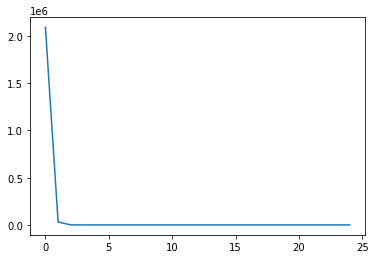

In [137]:
plt.plot(np.arange(len(inf['func_val'])),inf['func_val']);

#### Ответьте на следующие вопросы

1. По результатам экспериментов, какие параметры `step_alpha`, `step_beta` и `batch_size` вы считаете наиболее оптимальными? Если троек оптимальных параметров получилось несколько, какую пару вы выберете для дальнейших экпериментов и почему?

$\beta$ = 0.6

$\alpha$ = 1.29

batch_size = 20000


Опять же, при такой конфигурации получаем алгоритм с наибольшим balanced_accuracy, самым быстрым временем обучения. Более того градиентный спуск сходится к наименьшему значению функции ошибки.
    

2. Какие зависимости между параметрами `step_alpha`/`step_beta`/`batch_size` и временем работы алгоритма/кол-ва эпох вы наблюдаете? Опишите свои наблюдения.

При увеличении batch_size модель работает быстрее, так как приближение градиента более точное. 
При увеличении $\beta$ алгоритм также работает быстрее, причины тут такие же как в случае без батча.

### 3. Сравнение двух методов (2 балла)
Сравните поведение двух методов между собой, и ответьте на следующие вопросы

1. Какой алгоритм вы выберете для дальнейших экспериментов и почему?

SGD c упомянутыми выше параметрами работает быстрее с качеством на валидации чуть лучше, выберу его.

2. Есть ли разница между парами оптимальных параметров `step_alpha` и `step_beta` в двух алгоритмах? Объясните разницу/отсутствие разницы в результатах.

Без батча:

$\beta$ = 0.2

$\alpha$ = 1.29

C батчем:

$\beta$ = 0.6

$\alpha$ = 1.29

Шаг меньше, что позволяет на каждой итерации совершать более "осторожные" шаги по приближенному градиенту.
Альфа осталась такой же, видимо потому, что на стремление шага к нулю оно влияет не так сильно.

### 4. Регуляризация (2 балла)
Подберите по отложенной выборке коэффициент $l2$-регуляризации модели. 

Приведите график с результатами ваших экспериментов. Обоснуйте свой выбор.

In [99]:
res = {'r2_coef': [], 'acc': []}
coefs = np.arange(0.125, 2.0, 0.125)
for c in coefs:
    loss_function = BinaryLogisticLoss(l2_coef=c) 
    model = LinearModel(loss_function,step_alpha=alpha,batch_size=20000, step_beta=betha, max_iter=100, random_seed=1)
    inf = model.fit(X=X_train, y=y_train, w_0=None, trace=True, X_val=X_val, y_val=y_val)
    y_pred = model.predict(X_val, threshold=model.get_optimal_threshold(X_train, y_train))
    res['acc'].append(compute_balanced_accuracy(y_val, y_pred))
    res['r2_coef'].append(c)

convergence: 7.383405075179847e-06 < 1e-05
convergence: 8.496564650904278e-06 < 1e-05
convergence: 8.502366739806349e-06 < 1e-05
convergence: 7.154166055729894e-06 < 1e-05
convergence: 9.1480980457437e-06 < 1e-05
convergence: 8.034998286317522e-06 < 1e-05
convergence: 9.536691747761e-06 < 1e-05
convergence: 8.197474909010493e-06 < 1e-05
convergence: 8.494490877929872e-06 < 1e-05
convergence: 9.633482525605676e-06 < 1e-05
convergence: 9.690442776363268e-06 < 1e-05
convergence: 9.311609153439765e-06 < 1e-05


In [100]:
res = pd.DataFrame.from_dict(res)

In [101]:
res

,r2_coef,acc
0,0.125,0.831050
1,0.250,0.841491
2,0.375,0.840927
3,0.500,0.842398
4,0.625,0.845677
5,0.750,0.850603
6,0.875,0.866082
7,1.000,0.869821
8,1.125,0.867220
9,1.250,0.863467


Лучшее значение это 1. Так как на нем взвешенная точность на валидации максимальна.

### 5. Измерение качества и интерпретация результатов (3 балла)
Выберите лучший алгоритм для тестовой выборки. Обратите внимание, что необходимо использовать порог бинаризации, выбранный на отложенной выборке.

In [102]:
alpha

1.291549665014884

In [104]:
betha

0.6000000000000001

In [105]:
%%time
loss_function = BinaryLogisticLoss(l2_coef=1.0)
model = LinearModel(
    loss_function,
    batch_size=20000,
    step_alpha=alpha,
    step_beta=betha,
    tolerance=1e-5,
    max_iter=100,
    random_seed=2
)
inf = model.fit(X=X_train, y=y_train, w_0=None)

y_pred = model.predict(X_val, model.get_optimal_threshold(X_train, y_train))
acc = compute_balanced_accuracy(y_val, y_pred)
print('accuracy on val:',acc)

y_pred = model.predict(X_test, model.get_optimal_threshold(X_val, y_val))
acc = compute_balanced_accuracy(y_test, y_pred)
print('accuracy on test:',acc)


convergence: 8.170327128426811e-06 < 1e-05
accuracy on val: 0.8703010049046793
accuracy on test: 0.8625768483460634
CPU times: user 4.88 s, sys: 1.52 s, total: 6.4 s
Wall time: 1.18 s


#### Ответьте на следующие вопросы

1. Примените лучший алгоритм к тестовой выборке и посмотрите на метрику качества. Сравните ее с метрикой на валидации. Опишите ваши наблюдения.

Значения практически идентичны, подбирая параметры на валидационной выборке позволило сделать их оптимальными для теста.

2. Проанализируйте ошибки алгоритма. Проанализируйте и укажите общие черты объектов, на которых были допущены ошибки. Наблюдения опишите.

Большая часть ошибок сосредоточена в нетоксичных комментариях. Некоторые из них содержать некую часть ругательств и слов, которые алгоритм видимо привык расценивать как 'токсичные', например:

horrible, suicide, bastard, hell

In [106]:
ind = (y_pred != y_test) 

In [107]:
test.loc[ind & (test['is_toxic']==-1),'comment_text']

38           dare vandalize page hm beagle vandalize demon
655      utterly utterly tiny insignificant anal retent...
656      think origin sagging ha root human stupidity h...
700                       ech silly mensans iq point spare
743                                               cybersex
                               ...                        
63325    wa promising well known young model wa murdere...
63480                  please someone fix godawful article
63636    yeah sure say welcome discussion come right tu...
63827    might mention wa fault resolution wa amicable ...
63945    fourth baldrick possibly cleverer made doe any...
Name: comment_text, Length: 489, dtype: object

In [108]:
test.loc[ind & (test['is_toxic']==1),'comment_text']

1                                   dear god site horrible
12       jew race get mother mention ethiopian jew test...
17       balance page ha one sentence basic definition ...
27                       burn hell revoke talk page access
30                                         puwersa ng masa
                               ...                        
63958                suicide anyone know committed suicide
63964    added somebody using ip used ask hell ileana r...
63972            shut mexican border withought looking bad
63974    lucky bastard http wikimediafoundation org wik...
63975                        shame want speak gay romanian
Name: comment_text, Length: 11346, dtype: object

3. Проинтерпретируйте линейные коэффициенты признаков. Выберите коэффициенты с набиольшим значением и коэффициенты с наименьшим значением. Проанализируйте, каким словам они соответствуют. Согласуются ли ваши наблюдения с вашими ожиданиями от модели?

По видимому слово статья встречается в нетоксичных комментариях и повышает вероятность, что комментарий это скорее какое-то адекватно мнение комментатора. Насчет слова 'fuck', в принципе тоже понятно почему алгоритм относит комментарии с данным словом к токсичным, так как это самое распрастраненное ругательство.

In [109]:
words = np.array(trfrm.get_feature_names())
ind = model.get_weights() == model.get_weights()[1:].max()
words[ind[1:]]

array(['article'], dtype='<U21')

In [110]:
ind = model.get_weights() == model.get_weights()[1:].min()
words[ind[1:]]

array(['fuck'], dtype='<U21')